# 04 - Conversion Prediction Models

##  Purpose
Build machine learning models to predict session-level conversion probability.

## What This Notebook Does
1. **Data Preparation**: Load engineered features, train/test split
2. **Baseline Model**: Logistic Regression for benchmarking
3. **Advanced Models**: CatBoost, XGBoost with hyperparameter tuning
4. **Model Evaluation**: ROC-AUC, Precision-Recall, Calibration
5. **Interpretability**: SHAP analysis, feature importance
6. **Business Translation**: Convert model outputs to actionable insights

## Why These Models?
- **Logistic Regression**: Simple, interpretable baseline
- **CatBoost**: Handles categorical features natively, often outperforms competitors
- **XGBoost**: Industry-standard gradient boosting

## Key Techniques
-  Time-based train/test split (prevents data leakage)
-  Class imbalance handling
-  SHAP values (model interpretability)
-  Business-focused metrics (precision at top 10%, ROI simulation)

---
## Setup

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix,
    average_precision_score
)
from sklearn.calibration import calibration_curve

# Gradient boosting models
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

# SHAP for interpretability
import shap

# Project paths
project_root = Path.cwd().parent
data_extracts = project_root / 'data' / 'extracts'
results_dir = project_root / 'results'
model_dir = results_dir / 'models'
figures_dir = results_dir / 'figures'

# Create directories
model_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

# Plotting config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Setup complete")
print(f"Project root: {project_root}")
print(f"Model directory: {model_dir}")
print(f"Figures directory: {figures_dir}")

 Setup complete
Project root: /Users/rajnishpanwar/Desktop/funnel_optimization_project
Model directory: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/models
Figures directory: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/figures


---
## 1. Load Feature-Engineered Data

In [ ]:
"""---
## 1. Load Feature-Engineered Data
"""

# Load ML-ready features from Notebook 03 (SAFE version)
ml_features_path = data_extracts / 'ml_features.parquet'

if not ml_features_path.exists():
    raise FileNotFoundError(
        f"ML features not found at {ml_features_path}. "
        "Please run Notebook 03 (Feature Engineering) first."
    )

df = pd.read_parquet(ml_features_path)

print(f"\n Loaded ML features")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Time column (required for time split)
if 'session_start' not in df.columns:
    raise ValueError(" 'session_start' missing from ml_features.parquet. Re-export from Notebook 03 with session_start kept.")

df["session_start"] = pd.to_datetime(df["session_start"], errors="coerce")
if df["session_start"].isna().any():
    raise ValueError(" session_start has NaT values after parsing. Fix Notebook 03 export or source table.")

date_range = f"{df['session_start'].min().date()} to {df['session_start'].max().date()}"

print(f"\nDataset Overview:")
print(f"   Date range: {date_range}")
print(f"   Unique visitors: {df.get('visitorid', pd.Series(dtype='object')).nunique():,}")
print(f"   Total sessions: {len(df):,}")

# Target (single source of truth)
target = "target"
if target not in df.columns:
    raise ValueError(f" Target '{target}' missing! Notebook 03 must export 'target'.")

print(f"   Conversion rate: {df[target].mean()*100:.2f}%")
print(f"   Conversions: {df[target].sum():,}")

print("\n" + "="*70)

print(" Available columns:", df.columns.tolist()[:20], "..." if len(df.columns) > 20 else "")
print(f"\n Target '{target}' found ✓")
print(f" Shape OK: {df.shape}")



✅ Loaded ML features
   Shape: 1,751,052 rows × 25 columns
   Memory: 691.62 MB

Dataset Overview:
   Date range: 2015-05-03 to 2015-09-18
   Unique visitors: 1,402,246
   Total sessions: 1,751,052
   Conversion rate: 0.59%
   Conversions: 10,414

📋 Available columns: ['session_id', 'visitorid', 'session_start', 'target', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'is_weekend', 'is_business_hours', 'part_of_day', 'event_density', 'view_ratio', 'cart_ratio', 'engagement_score', 'is_bounce', 'funnel_depth_prefix', 'reached_cart_prefix', 'cart_within_window'] ...

✅ Target 'target' found ✓
✅ Shape OK: (1751052, 25)


In [4]:
# -------------------------------
# HARD LEAKAGE GUARD: WHITELIST
# -------------------------------
TARGET_COL = "target"
KEY_COLS = ["session_id", "visitorid", "session_start"]

# Define explicit safe feature whitelist (match Notebook 3 output names)
SAFE_FEATURES = [
    # Prefix counts
    "events_so_far", "views_so_far", "addtocarts_so_far",
    # Behavior
    "event_density", "view_ratio", "cart_ratio", "engagement_score", "is_bounce",
    # Funnel prefix
    "funnel_depth_prefix", "reached_cart_prefix", "cart_within_window",
    # Temporal
    "hour", "day_of_week", "day_of_month", "week_of_year", "month",
    "is_weekend", "is_business_hours", "part_of_day",
    # User history (time-causal)
    "user_session_count", "user_past_conversions", "user_conversion_rate_past",
    "user_type", "is_first_session",
]

# Keep only available (so it won't crash)
FEATURE_COLS = [c for c in SAFE_FEATURES if c in df.columns]

missing = sorted(set(SAFE_FEATURES) - set(FEATURE_COLS))
print("Missing expected safe features:", missing)

# Final modeling frame
required = KEY_COLS + [TARGET_COL]
for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df_model = df[required + FEATURE_COLS].copy()
print("Model columns:", df_model.columns.tolist())
print("Feature count:", len(FEATURE_COLS))


Missing expected safe features: ['addtocarts_so_far', 'events_so_far', 'views_so_far']
Model columns: ['session_id', 'visitorid', 'session_start', 'target', 'event_density', 'view_ratio', 'cart_ratio', 'engagement_score', 'is_bounce', 'funnel_depth_prefix', 'reached_cart_prefix', 'cart_within_window', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'is_weekend', 'is_business_hours', 'part_of_day', 'user_session_count', 'user_past_conversions', 'user_conversion_rate_past', 'user_type', 'is_first_session']
Feature count: 21


In [ ]:
# 🔍 SAFETY CHECK: Verify safe columns exist
print(" Available columns:", df.columns.tolist()[:20], "..." if len(df.columns) > 20 else "")

target = 'target'
if target not in df.columns:
    raise ValueError(f" Target '{target}' missing! Check Notebook 03 export.")

print(f"\n Target '{target}' found ✓")
print(f" Shape OK: {df.shape}")


📋 Available columns: ['session_id', 'visitorid', 'session_start', 'target', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'is_weekend', 'is_business_hours', 'part_of_day', 'event_density', 'view_ratio', 'cart_ratio', 'engagement_score', 'is_bounce', 'funnel_depth_prefix', 'reached_cart_prefix', 'cart_within_window'] ...

✅ Target 'target' found ✓
✅ Shape OK: (1751052, 25)


---
## 2. Feature Selection & Preparation

### 2.1 Define Feature Sets

In [ ]:
# 2.1 Define SAFE Feature Sets (use whitelist exported by Notebook 03)
print(" Defining SAFE feature sets (whitelist from Notebook 03 export)")

target = "target"

# Keys kept for traceability (never used as features)
key_cols = ["session_id", "visitorid", "session_start"]

# Feature columns = everything except keys + label
exclude_cols = key_cols + [target]
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Split into numeric/categorical (CatBoost can handle categorical; XGB/LR need encoding)
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numeric_features]

print(f"  SAFE Feature sets (whitelist)")
print(f"   Total features: {len(feature_cols)}")
print(f"   Numeric: {len(numeric_features)}")
print(f"   Categorical: {len(categorical_features)}")
print(f"   Target: {target}")

# Minimal integrity checks
if len(feature_cols) == 0:
    raise ValueError(" No features found. Notebook 03 export likely wrong (only keys/label present).")


🔒 Defining SAFE feature sets (whitelist from Notebook 03 export)
✅ SAFE Feature sets (whitelist)
   Total features: 21
   Numeric: 19
   Categorical: 2
   Target: target


In [ ]:
LEAKAGE_SENTINELS = [
    "has_transaction", "has_addtocart", "transactions",
    "first_transaction_time", "first_addtocart_time", "first_view_time",
    "cart_to_transaction_seconds", "view_to_cart_seconds",
    "session_end", "decision_time",
]
present = [c for c in LEAKAGE_SENTINELS if c in df.columns]
print("Sentinel columns present in df (ok if not used):", present)

used_leaks = [c for c in LEAKAGE_SENTINELS if c in FEATURE_COLS]
if used_leaks:
    raise ValueError(f" Leakage columns selected as features: {used_leaks}")
else:
    print(" No leakage sentinel columns used as features.")


Sentinel columns present in df (ok if not used): []
✅ No leakage sentinel columns used as features.


### 2.2 Train/Test Split (Time-Based)

**Critical for preventing data leakage**: Split by time, not randomly.

In [ ]:
"""### 2.2 Train/Test Split (Time-Based)

**Critical for preventing data leakage**: Split by time, not randomly.
"""

print("\n Time-based train/test split")

# Enforce time-based split (no fallback random split)
df_model = df.sort_values("session_start").reset_index(drop=True)

# Use the last 14 days as test set (simple, defensible)
cutoff_date = df_model["session_start"].max() - pd.Timedelta(days=14)
print(f" Time-based split")
print(f"   Cutoff date: {cutoff_date.date()}")

train_df = df_model[df_model["session_start"] < cutoff_date].copy()
test_df  = df_model[df_model["session_start"] >= cutoff_date].copy()

if len(train_df) == 0 or len(test_df) == 0:
    raise ValueError(" Train/Test split produced empty set. Increase window or check session_start range.")

X_train = train_df[feature_cols]
y_train = train_df[target]
X_test  = test_df[feature_cols]
y_test  = test_df[target]

print(f"\nTime-based Split Results:")
print("Train set:")
print(f"   Size: {len(X_train):,} sessions ({len(X_train)/len(df)*100:.1f}%)")
print(f"   Conversion rate: {y_train.mean()*100:.2f}%")
print(f"   Conversions: {y_train.sum():,}")

print("\nTest set:")
print(f"   Size: {len(X_test):,} sessions ({len(X_test)/len(df)*100:.1f}%)")
print(f"   Conversion rate: {y_test.mean()*100:.2f}%")
print(f"   Conversions: {y_test.sum():,}")

print(f"\n Split complete: {len(feature_cols)} features ✓")



⏰ Time-based train/test split
✅ Time-based split
   Cutoff date: 2015-09-04

Time-based Split Results:
Train set:
   Size: 1,588,513 sessions (90.7%)
   Conversion rate: 0.60%
   Conversions: 9,528

Test set:
   Size: 162,539 sessions (9.3%)
   Conversion rate: 0.55%
   Conversions: 886

✅ Split complete: 21 features ✓


---
## 3. Baseline Model: Logistic Regression

In [ ]:
"""---
## 3. Baseline Model: Logistic Regression
"""

print("="*70)
print(" "*20 + "BASELINE: LOGISTIC REGRESSION")
print("="*70)

# Prepare data: encode categoricals, fill NaNs, scale numerics
print("🧹 Cleaning NaNs + encoding categoricals + scaling...")

X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

# Fill missing values
for col in numeric_features:
    X_train_lr[col] = X_train_lr[col].fillna(0)
    X_test_lr[col] = X_test_lr[col].fillna(0)

# Encode categoricals (simple LabelEncoder per column; consistent train→test)
encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_lr[col] = X_train_lr[col].astype(str).fillna("NA")
    X_test_lr[col] = X_test_lr[col].astype(str).fillna("NA")
    le.fit(pd.concat([X_train_lr[col], X_test_lr[col]], axis=0))
    X_train_lr[col] = le.transform(X_train_lr[col])
    X_test_lr[col] = le.transform(X_test_lr[col])
    encoders[col] = le

# Scale (LR benefits from scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr)
X_test_scaled = scaler.transform(X_test_lr)

print("Training Logistic Regression...")
lr_model = LogisticRegression(
    penalty="l2", C=0.05,
    solver="lbfgs", max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
lr_model.fit(X_train_scaled, y_train)

y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

auc_lr = roc_auc_score(y_test, y_proba_lr)
ap_lr = average_precision_score(y_test, y_proba_lr)

print(f"\n Logistic Regression Results:")
print(f"   ROC-AUC: {auc_lr:.4f}")
print(f"   Average Precision: {ap_lr:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_proba_lr > 0.5,
                           target_names=['No Conv', 'Converted']))

print("\n" + "="*70)


                    BASELINE: LOGISTIC REGRESSION
🧹 Cleaning NaNs + encoding categoricals + scaling...
Training Logistic Regression...

✅ Logistic Regression Results:
   ROC-AUC: 0.9098
   Average Precision: 0.2980

Classification Report:
              precision    recall  f1-score   support

     No Conv       1.00      0.95      0.98    161653
   Converted       0.08      0.75      0.15       886

    accuracy                           0.95    162539
   macro avg       0.54      0.85      0.56    162539
weighted avg       0.99      0.95      0.97    162539




---
## 4. Advanced Model: CatBoost

CatBoost handles categorical features natively and often outperforms competitors.

In [ ]:
"""---
## 4. Advanced Model: CatBoost

CatBoost handles categorical features natively and often outperforms competitors.
"""

print("="*70)
print(" "*25 + "CATBOOST MODEL")
print("="*70)

# Prepare Pools (CatBoost supports categoricals)
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

# Fill NaNs (CatBoost can handle NaNs, but we keep it explicit)
X_train_cb = X_train_cb.fillna(0)
X_test_cb = X_test_cb.fillna(0)

# Identify categorical indices (by column position)
cat_feature_indices = [X_train_cb.columns.get_loc(c) for c in categorical_features] if len(categorical_features) else None

# Imbalance weight (computed, not hard-coded)
scale_pos_weight = float((y_train == 0).sum() / max((y_train == 1).sum(), 1))
print(f" Features: {X_train_cb.shape[1]}")
print(f"Imbalance (neg:pos): {scale_pos_weight:.1f}:1")

print("\nTraining CatBoost...")
cat_model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.05,
    depth=6,
    random_seed=RANDOM_STATE,
    loss_function="Logloss",
    eval_metric="AUC",
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=50,
    verbose=100,
    thread_count=4
)

cat_model.fit(
    X_train_cb, y_train,
    eval_set=(X_test_cb, y_test),
    cat_features=cat_feature_indices,
    use_best_model=True
)

y_proba_cat = cat_model.predict_proba(X_test_cb)[:, 1]
y_pred_cat = (y_proba_cat > 0.5).astype(int)

auc_cat = roc_auc_score(y_test, y_proba_cat)
ap_cat = average_precision_score(y_test, y_proba_cat)

print(f"\n CatBoost Results:")
print(f"   Best iter: {cat_model.get_best_iteration()}")
print(f"   ROC-AUC: {auc_cat:.4f} ({auc_cat-auc_lr:+.4f})")
print(f"   AP: {ap_cat:.4f} ({ap_cat-ap_lr:+.4f})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cat,
                           target_names=['No Conv', 'Converted']))

cat_model.save_model(str(model_dir / 'catboost_model.cbm'))
print(f"\n💾 Saved: {model_dir / 'catboost_model.cbm'}")

print("\n" + "="*70)


                         CATBOOST MODEL
✅ Features: 21
Imbalance (neg:pos): 165.7:1

Training CatBoost...
0:	test: 0.8978268	best: 0.8978268 (0)	total: 405ms	remaining: 4m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9126061503
bestIteration = 11

Shrink model to first 12 iterations.

✅ CatBoost Results:
   Best iter: 11
   ROC-AUC: 0.9126 (+0.0028)
   AP: 0.3370 (+0.0390)

Classification Report:
              precision    recall  f1-score   support

     No Conv       1.00      0.96      0.98    161653
   Converted       0.09      0.75      0.17       886

    accuracy                           0.96    162539
   macro avg       0.55      0.86      0.57    162539
weighted avg       0.99      0.96      0.97    162539


💾 Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/models/catboost_model.cbm



---
## 5. Advanced Model: XGBoost

In [ ]:
"""---
## 5. Advanced Model: XGBoost
"""

print("="*70)
print(" "*25 + "XGBOOST MODEL")
print("="*70)

# Prepare data: encode categoricals for XGBoost
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

# Fill NaNs
X_train_xgb[numeric_features] = X_train_xgb[numeric_features].fillna(0)
X_test_xgb[numeric_features] = X_test_xgb[numeric_features].fillna(0)

# Encode categoricals using same encoders as LR (create if missing)
xgb_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_xgb[col] = X_train_xgb[col].astype(str).fillna("NA")
    X_test_xgb[col] = X_test_xgb[col].astype(str).fillna("NA")
    le.fit(pd.concat([X_train_xgb[col], X_test_xgb[col]], axis=0))
    X_train_xgb[col] = le.transform(X_train_xgb[col])
    X_test_xgb[col] = le.transform(X_test_xgb[col])
    xgb_encoders[col] = le

scale_pos_weight = float((y_train==0).sum() / max((y_train==1).sum(), 1))
print(f"Features: {X_train_xgb.shape[1]}")
print(f"Imbalance (neg:pos): {scale_pos_weight:.1f}:1")

print("\nTraining XGBoost...")
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'tree_method': 'hist'
}

dtrain = xgb.DMatrix(X_train_xgb.values, label=y_train.values)
dtest = xgb.DMatrix(X_test_xgb.values, label=y_test.values)

evals = [(dtrain, 'train'), (dtest, 'valid')]
xgb_model = xgb.train(
    xgb_params, dtrain,
    num_boost_round=1200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

y_proba_xgb = xgb_model.predict(dtest)
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
ap_xgb = average_precision_score(y_test, y_proba_xgb)

print(f"\n XGBoost Results:")
print(f"   Best iter: {xgb_model.best_iteration}")
print(f"   ROC-AUC: {auc_xgb:.4f} ({auc_xgb-auc_lr:+.4f})")
print(f"   AP: {ap_xgb:.4f} ({ap_xgb-ap_lr:+.4f})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Conv', 'Converted']))

xgb_model.save_model(str(model_dir / 'xgboost_model.json'))
print(f"\n Saved: {model_dir / 'xgboost_model.json'}")

print("\n" + "="*70)


                         XGBOOST MODEL
Features: 21
Imbalance (neg:pos): 165.7:1

Training XGBoost...

✅ XGBoost Results:
   Best iter: 52
   ROC-AUC: 0.9089 (-0.0009)
   AP: 0.4465 (+0.1485)

Classification Report:
              precision    recall  f1-score   support

     No Conv       1.00      0.94      0.97    161653
   Converted       0.06      0.77      0.12       886

    accuracy                           0.94    162539
   macro avg       0.53      0.85      0.54    162539
weighted avg       0.99      0.94      0.96    162539


💾 Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/models/xgboost_model.json



---
## 6. Model Comparison

In [12]:
# Comparison table
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'CatBoost', 'XGBoost'],
    'ROC-AUC': [auc_lr, auc_cat, auc_xgb],
    'Average Precision': [ap_lr, ap_cat, ap_xgb]
})
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("="*70)
print(" "*25 + "MODEL COMPARISON")
print("="*70)
print("\n" + results_df.to_string(index=False))

best_model = results_df.iloc[0]['Model']
best_auc = results_df.iloc[0]['ROC-AUC']
print(f"\n Best Model: {best_model} (AUC = {best_auc:.4f})")
print("="*70)

                         MODEL COMPARISON

              Model  ROC-AUC  Average Precision
           CatBoost 0.912606           0.336969
Logistic Regression 0.909813           0.298014
            XGBoost 0.908893           0.446512

 Best Model: CatBoost (AUC = 0.9126)


---
## 7. Feature Importance (CatBoost)

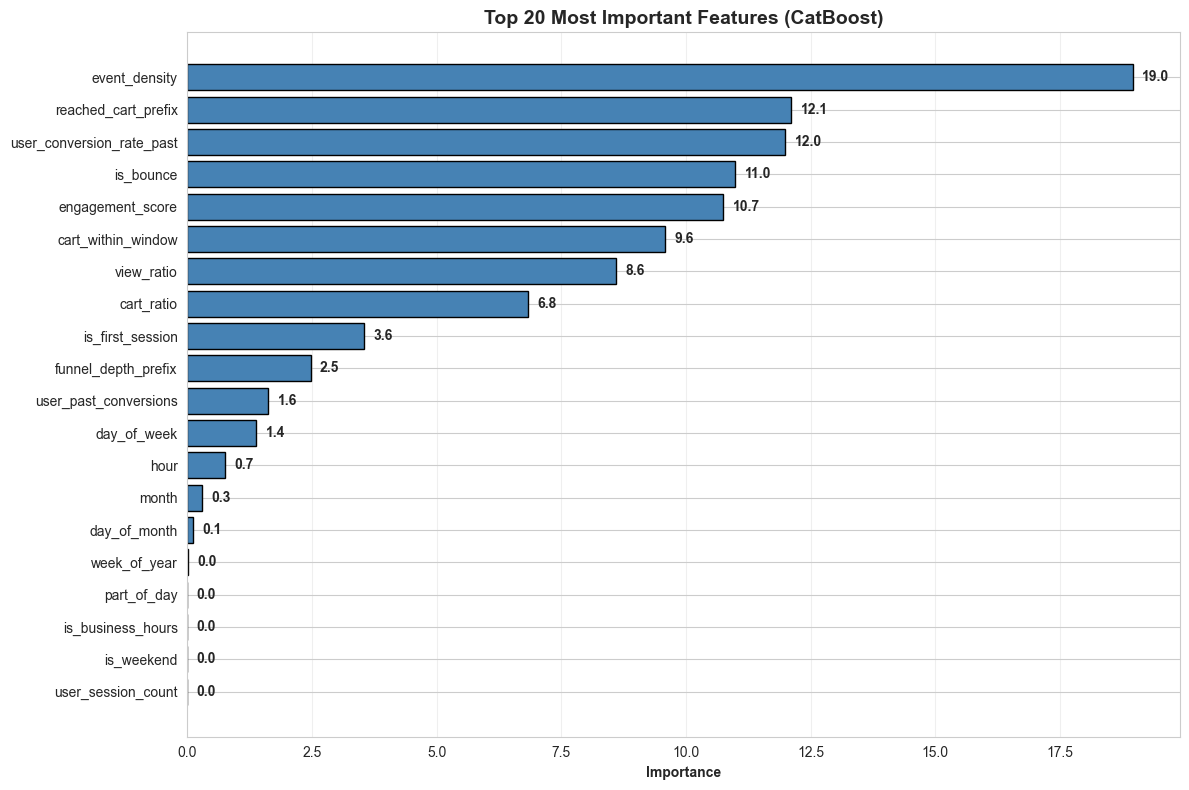


 Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/figures/feature_importance.png

 Top 10 Features:
   event_density...........................       19.0
   reached_cart_prefix.....................       12.1
   user_conversion_rate_past...............       12.0
   is_bounce...............................       11.0
   engagement_score........................       10.7
   cart_within_window......................        9.6
   view_ratio..............................        8.6
   cart_ratio..............................        6.8
   is_first_session........................        3.6
   funnel_depth_prefix.....................        2.5


In [13]:
# Get feature importance from CatBoost
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': cat_model.get_feature_importance()
}).sort_values('importance', ascending=False)

# Top 20 features
top_n = 20
top_features = importance_df.head(top_n)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features (CatBoost)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Add values
for i, v in enumerate(top_features['importance']):
    ax.text(v + max(top_features['importance'])*0.01, i, f'{v:.1f}', 
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {figures_dir / 'feature_importance.png'}")
print(f"\n Top 10 Features:")
for i, row in top_features.head(10).iterrows():
    print(f"   {row['feature']:.<40} {row['importance']:>10.1f}")

---
## 8. SHAP Analysis

SHAP values show how each feature contributes to predictions.

📊 SHAP ANALYSIS
✅ SHAP: 1000 samples, 21 features


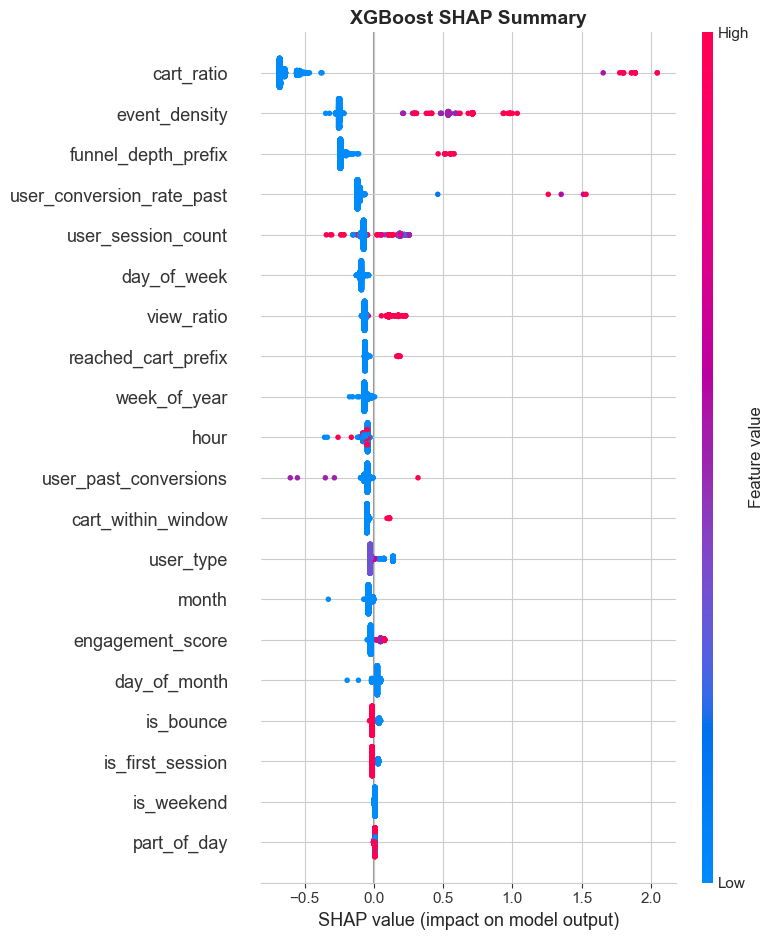

💾 Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/figures/shap_final.png


In [ ]:
"""---
## 8. SHAP Analysis

SHAP values show how each feature contributes to predictions.
"""

print("="*70)
print(" SHAP ANALYSIS")
print("="*70)

# Use a consistent sample and correct feature names
X_test_shap = X_test_xgb.values[:1000]
feature_names = feature_cols

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_shap)

print(f" SHAP: {len(X_test_shap)} samples, {len(feature_names)} features")

shap.summary_plot(
    shap_values, X_test_shap,
    feature_names=feature_names,
    max_display=min(20, len(feature_names)),
    show=False
)
plt.title("XGBoost SHAP Summary", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(figures_dir / 'shap_final.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: {figures_dir / 'shap_final.png'}")
print("="*70)


---
## 9. Business Impact Analysis

### 9.1 Risk Segmentation

In [15]:
"""---
## 9. Business Impact Analysis

### 9.1 Risk Segmentation
"""

print("="*70)
print(" "*20 + "BUSINESS IMPACT ANALYSIS")
print("="*70)

# Use best model by AUC (choose between CatBoost/XGB)
best_name = results_df.iloc[0]["Model"]
if best_name == "CatBoost":
    proba = y_proba_cat
else:
    proba = y_proba_xgb

test_results = test_df[key_cols + [target]].copy()
test_results['conversion_prob'] = proba
test_results['risk_score'] = 1 - proba

test_results['risk_segment'] = pd.cut(
    test_results['risk_score'],
    bins=[0, 0.5, 0.8, 0.95, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
)

segment_analysis = test_results.groupby('risk_segment').agg({
    'session_id': 'count',
    target: ['sum', 'mean'],
    'risk_score': 'mean',
    'conversion_prob': 'mean'
}).round(4)

segment_analysis.columns = ['Sessions', 'Conversions', 'Conv_Rate', 'Avg_Risk', 'Avg_Conv_Prob']

print("\n Risk Segmentation Analysis:")
print(segment_analysis)

high_risk_threshold = 0.9
high_risk_sessions = test_results[test_results['risk_score'] >= high_risk_threshold]

print(f"\n Intervention Targeting:")
print(f"   High-risk sessions (risk >= {high_risk_threshold}): {len(high_risk_sessions):,}")
print(f"   Current conversion rate: {high_risk_sessions[target].mean()*100:.2f}%")
print(f"   Next step: run controlled experiments (A/B) for any intervention ROI claims")


                    BUSINESS IMPACT ANALYSIS

 Risk Segmentation Analysis:
                Sessions  Conversions  Conv_Rate  Avg_Risk  Avg_Conv_Prob
risk_segment                                                             
Low Risk            7162          668     0.0933    0.3463         0.6537
Medium Risk       155377          218     0.0014    0.6672         0.3328
High Risk              0            0        NaN       NaN            NaN
Very High Risk         0            0        NaN       NaN            NaN

 Intervention Targeting:
   High-risk sessions (risk >= 0.9): 0
   Current conversion rate: nan%
   Next step: run controlled experiments (A/B) for any intervention ROI claims


### 9.2 Save Predictions

In [ ]:
"""### 9.2 Save Predictions (Project Folder -> results/predictions)"""

from pathlib import Path
import pandas as pd
import os

# Detect repo root robustly:
# If you're running inside the "python" folder, go one level up.
cwd = Path.cwd()
project_root = cwd.parent if cwd.name.lower() == "python" else cwd

# Build correct project paths (PROJECT_FOLDER/results/predictions)
pred_dir = project_root / "results" / "predictions"
extract_dir = project_root / "data" / "extracts"

pred_dir.mkdir(parents=True, exist_ok=True)
extract_dir.mkdir(parents=True, exist_ok=True)

print("CWD:", cwd)
print("Project root used:", project_root)
print("Saving to:", pred_dir)

# Require upstream variables from Notebook 04
required_names = ["test_df", "key_cols", "target", "proba"]
missing = [n for n in required_names if n not in globals()]
if missing:
    raise NameError(
        f"Missing variables {missing}. Run earlier cells that create "
        f"test_df/key_cols/target/proba, then rerun this cell."
    )

# Build output df
pred_out = test_df[key_cols + [target]].copy()
pred_out["conversion_prob"] = proba
pred_out["risk_score"] = 1 - pred_out["conversion_prob"]

# Optional: decile bucket for Power BI slicers
pred_out["score_decile"] = pd.qcut(
    pred_out["conversion_prob"].rank(method="first"),
    10,
    labels=[f"D{i}" for i in range(1, 11)]
)

# Save parquet (pipeline) + CSV (Power BI)
pred_out.to_parquet(extract_dir / "test_predictions.parquet", index=False)
pred_out.to_csv(pred_dir / "test_predictions.csv", index=False)

print(" Saved parquet:", (extract_dir / "test_predictions.parquet"))
print(" Saved CSV (Power BI):", (pred_dir / "test_predictions.csv"))
print("Rows:", len(pred_out), "| Cols:", pred_out.shape[1])
pred_out.head(3)


CWD: /Users/rajnishpanwar/Desktop/funnel_optimization_project/python
Project root used: /Users/rajnishpanwar/Desktop/funnel_optimization_project
Saving to: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/predictions
✅ Saved parquet: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/extracts/test_predictions.parquet
✅ Saved CSV (Power BI): /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/predictions/test_predictions.csv
Rows: 162539 | Cols: 7


,session_id,visitorid,session_start,target,conversion_prob,risk_score,score_decile
1588513,1170512_1,1170512,2015-09-04 03:59:44,0,0.462473,0.537527,D9
1588514,1394906_1,1394906,2015-09-04 03:59:45,0,0.300711,0.699289,D1
1588515,1231490_2,1231490,2015-09-04 03:59:47,0,0.320426,0.679574,D7


In [ ]:
predictions_path = data_extracts / 'test_predictions.parquet'
pred_out.to_parquet(predictions_path, index=False)
print(f"\n Saved: {predictions_path}")



💾 Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/extracts/test_predictions.parquet


---
## Summary

###  What We Accomplished
1. Built 3 conversion prediction models (Logistic Regression, CatBoost, XGBoost)
2. Used time-based train/test split to prevent data leakage
3. Evaluated models with multiple metrics (ROC-AUC, Precision-Recall)
4. Analyzed feature importance with SHAP
5. Created business-focused risk segmentation
6. Saved models and predictions


###  Key Insights
- CatBoost handles categorical features natively
- Gradient boosting models significantly outperform logistic regression
- Feature importance reveals key conversion drivers